In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

## Read data file and some glimpse on raw data

In [2]:
filename = "experiment_data_lstm.csv"
df = pd.read_csv(filename, header=0, sep=',', dtype=np.float64)
print('Are ther any Nan value?:\n', np.isnan(df).any())
# ignore rows which contain zero
# ignore rows which have negative instantaneous rate
ignore_zero = df[(df['Strain']==0) | (df['Stress']==0) | (df['Temperature']==0) | (df['Strain Rate']<=0) ]
df=pd.concat([df, ignore_zero, ignore_zero]).drop_duplicates(keep=False)
df=pd.concat([df, ignore_zero, ignore_zero]).drop_duplicates(keep=False)
df.head()

Are ther any Nan value?:
 Strain               False
Stress               False
Strain Rate          False
Temperature          False
Normalized Stress    False
dtype: bool


,Strain,Stress,Strain Rate,Temperature,Normalized Stress
1,0.0002,580.282200,0.0001,298.0,1.000000
2,0.0004,644.631000,0.0001,298.0,1.110892
3,0.0006,681.693300,0.0001,298.0,1.174762
4,0.0008,706.112533,0.0001,298.0,1.216843
5,0.0010,727.073400,0.0001,298.0,1.252965


## Splitting flow curves

The individual flow curves are stacked one after the other in the csv file, so they need to be split according to the strain rate and temperature

In [3]:
# Flow curves in different strain rates at RT
df_e4 = df[(df['Strain Rate']==0.0001) & (df['Temperature']==298.0)]
df_e3 = df[(df['Strain Rate']==0.001) & (df['Temperature']==298.0)]
df_e2 = df[(df['Strain Rate']==0.01) & (df['Temperature']==298.0)]
df_e1 = df[(df['Strain Rate']==0.1) & (df['Temperature']==298.0)]

In [4]:
# Flow curves in 0.1 strain rate at varying T
df_e1_RT = df[(df['Strain Rate']==0.1) & (df['Temperature']==298.0)]
df_e1_373K = df[(df['Strain Rate']==0.1) & (df['Temperature']==373.0)]
df_e1_473K = df[(df['Strain Rate']==0.1) & (df['Temperature']==473.0)]
df_e1_573K = df[(df['Strain Rate']==0.1) & (df['Temperature']==573.0)]
df_e1_673K = df[(df['Strain Rate']==0.1) & (df['Temperature']==673.0)]

In [5]:
# Flow curves in 0.01 strain rate at varying T
df_e2_RT = df[(df['Strain Rate']==0.01) & (df['Temperature']==298.0)]
df_e2_373K = df[(df['Strain Rate']==0.01) & (df['Temperature']==373.0)]
df_e2_473K = df[(df['Strain Rate']==0.01) & (df['Temperature']==473.0)]
df_e2_573K = df[(df['Strain Rate']==0.01) & (df['Temperature']==573.0)]
df_e2_673K = df[(df['Strain Rate']==0.01) & (df['Temperature']==673.0)]

In [6]:
# Flow curves in 0.001 strain rate at varying T
df_e3_RT = df[(df['Strain Rate']==0.001) & (df['Temperature']==298.0)]
df_e3_373K = df[(df['Strain Rate']==0.001) & (df['Temperature']==373.0)]
df_e3_473K = df[(df['Strain Rate']==0.001) & (df['Temperature']==473.0)]
df_e3_573K = df[(df['Strain Rate']==0.001) & (df['Temperature']==573.0)]
df_e3_673K = df[(df['Strain Rate']==0.001) & (df['Temperature']==673.0)]

In [7]:
# Flow curves in 0.0001 strain rate at varying T
df_e4_RT = df[(df['Strain Rate']==0.0001) & (df['Temperature']==298.0)]
df_e4_373K = df[(df['Strain Rate']==0.0001) & (df['Temperature']==373.0)]
df_e4_473K = df[(df['Strain Rate']==0.0001) & (df['Temperature']==473.0)]
df_e4_573K = df[(df['Strain Rate']==0.0001) & (df['Temperature']==573.0)]
df_e4_673K = df[(df['Strain Rate']==0.0001) & (df['Temperature']==673.0)]

In [8]:
# Put all flow curves in a dictionary for easy access 
flows = {'e4': df_e4,
         'e4_373K': df_e4_373K,
         'e4_473K': df_e4_473K,
         'e4_573K': df_e4_573K,
         'e4_673K': df_e4_673K,
         'e3': df_e3,
         'e3_373K': df_e3_373K,
         'e3_473K': df_e3_473K,
         'e3_573K': df_e3_573K,
         'e3_673K': df_e3_673K,
         'e2': df_e2,
         'e2_373K': df_e2_373K,
         'e2_473K': df_e2_473K,
         'e2_573K': df_e2_573K,
         'e2_673K': df_e2_673K,
         'e1': df_e1,
         'e1_373K': df_e1_373K,
         'e1_473K': df_e1_473K,
         'e1_573K': df_e1_573K,
         'e1_673K': df_e1_673K
        }
# Iterate through the flows dictionary and print the shape of each DataFrame
for key, df in flows.items():
    print(f"Shape of {key}: {df.shape}")

Shape of e4: (241, 5)
Shape of e4_373K: (528, 5)
Shape of e4_473K: (567, 5)
Shape of e4_573K: (468, 5)
Shape of e4_673K: (512, 5)
Shape of e3: (234, 5)
Shape of e3_373K: (526, 5)
Shape of e3_473K: (607, 5)
Shape of e3_573K: (772, 5)
Shape of e3_673K: (596, 5)
Shape of e2: (94, 5)
Shape of e2_373K: (552, 5)
Shape of e2_473K: (533, 5)
Shape of e2_573K: (691, 5)
Shape of e2_673K: (579, 5)
Shape of e1: (48, 5)
Shape of e1_373K: (61, 5)
Shape of e1_473K: (45, 5)
Shape of e1_573K: (64, 5)
Shape of e1_673K: (64, 5)


## Preprocessing

In this section, the data is first normalised, then split into train-test data, and finally split into features and labels.

In [9]:
# First, logarithm is applied to strain and strain rate before normalising.

flows_log = {}
for key, fc in flows.items():
    fc = fc.reset_index(drop=True)
    # apply decadic log to strain rates
    log_rate = pd.DataFrame(np.log10(fc['Strain Rate'].values))
    log_rate.columns = ['log_rate']
    # apply decadic log to strain
    log_strain = pd.DataFrame(np.log10(fc['Strain'].values))
    log_strain.columns = ['log_strain']
    
    fc_log = pd.concat([fc, log_strain, log_rate], axis=1)
    fc_log = fc_log.drop(columns=['Strain', 'Strain Rate'])
    cols = ['log_strain', 'log_rate', 'Temperature', 'Stress', 'Normalized Stress']
    fc_log = fc_log[cols]
    flows_log[key] = fc_log
raw_features = len(flows_log['e4'].columns.values)
flows_log['e4'].columns.values

array(['log_strain', 'log_rate', 'Temperature', 'Stress',
       'Normalized Stress'], dtype=object)

In [10]:
# Normalise the data according to the min-max formula

flows_scaled = {}
#stress_range = np.array([40, 570])
#temp_range = np.array([290, 700])
# Get the range for Stress
stress_min = df['Normalized Stress'].min()
stress_max = df['Normalized Stress'].max()
stress_range = np.array([stress_min, stress_max])

# Get the range for Temp (Temperature)
temp_min = df['Temperature'].min()
temp_max = df['Temperature'].max()
temp_range = np.array([298,673])

log_strain_range = [np.log10(0.08068), np.log10(1e-9)] # valid only if strain < 1.0
log_rate_range = [np.log10(0.1), np.log10(0.0001)] # valid only if rate < 1.0

def manual_scaling(feat, range_value):
    return (feat - range_value[0])/range_value[1]
def manual_descaling(feat, range_value): # inverse of the function above
    return feat * range_value[1] + range_value[0]

for key, fc in flows_log.items():
    fc['Normalized Stress'] = manual_scaling(fc['Normalized Stress'], stress_range)
    fc['Temperature'] = manual_scaling(fc['Temperature'], temp_range)
    fc['log_strain'] = manual_scaling(fc['log_strain'], log_strain_range)
    fc['log_rate'] = manual_scaling(fc['log_rate'], log_rate_range)
    flows_scaled[key] = fc
flows_scaled['e4_373K'].head()

,log_strain,log_rate,Temperature,Stress,Normalized Stress
0,0.400637,0.75,0.111441,571.162231,0.036753
1,0.434085,0.75,0.111441,579.519959,0.045409
2,0.367190,0.75,0.111441,587.720642,0.053902
3,0.356422,0.75,0.111441,595.775391,0.062244
4,0.381072,0.75,0.111441,603.783569,0.070537


## Decompose train and test set

In [11]:
train_set_name = ['e4', 'e4_373K', 'e4_573K', 'e4_673K', 
                  'e3', 'e3_373K', 'e3_473K', 'e3_573K', 'e3_673K',
                  'e2', 'e2_373K', 'e2_473K','e2_573K', 'e2_673K', 
                  'e1', 'e1_373K', 'e1_473K', 'e1_573K', 'e1_673K']
test_set_name = ['e4_473K']

train_set = []
test_set = []
val_set = []
exp_no_T = []

for key, fc in flows_scaled.items():
    if key in train_set_name:
        train_set.append(fc)
    if key in test_set_name:
        test_set.append(fc)
    else:
        exp_no_T.append(fc)
        
df_train = pd.concat(train_set)
df_test = pd.concat(test_set)

In [12]:
flows_scaled.keys()

dict_keys(['e4', 'e4_373K', 'e4_473K', 'e4_573K', 'e4_673K', 'e3', 'e3_373K', 'e3_473K', 'e3_573K', 'e3_673K', 'e2', 'e2_373K', 'e2_473K', 'e2_573K', 'e2_673K', 'e1', 'e1_373K', 'e1_473K', 'e1_573K', 'e1_673K'])

## Decompose label and feature

In [13]:
lbl_name = ['Normalized Stress']

ignore_cols = ['Stress']

def decomp_label_feat(df, lbl_col, ignore_cols=[]):
    label = pd.DataFrame(df[lbl_col])
    ignore_cols.append(lbl_col[0])
    feat = df.drop(columns=ignore_cols)
    return feat.values, label.values

def restore_strain(log_strain_col, range_value):
    log_strain = manual_descaling(log_strain_col, log_strain_range)
    return 10**log_strain

print('Original columns: \n\n',cols,'\n')
print('Label column...', lbl_name, '\n')
print('Ignore columns...', ignore_cols, '\n')


X_train, y_train = decomp_label_feat(df_train, lbl_name, ignore_cols)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
X_test, y_test = decomp_label_feat(df_test, lbl_name, ignore_cols)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


# Organise the training and testing flow curves into their respective dictionaries for easy access
X_test_dict = {}
y_test_dict = {}
for ii, df_test in enumerate(test_set):
    X_test_dict[test_set_name[ii]], y_test_dict[test_set_name[ii]] = decomp_label_feat(df_test, lbl_name, ignore_cols)
    print('X_test shape for set ' + test_set_name[ii], X_test_dict[test_set_name[ii]].shape)
    print('y_test shape for set ' + test_set_name[ii], y_test_dict[test_set_name[ii]].shape)

X_train_dict = {}
y_train_dict = {}
for jj, df_train in enumerate(train_set):
    X_train_dict[train_set_name[jj]], y_train_dict[train_set_name[jj]] = decomp_label_feat(df_train, lbl_name, ignore_cols)
    print('X_train shape for set ' + train_set_name[jj], X_train_dict[train_set_name[jj]].shape)
    print('y_train shape for set ' + train_set_name[jj], y_train_dict[train_set_name[jj]].shape)

Original columns: 

 ['log_strain', 'log_rate', 'Temperature', 'Stress', 'Normalized Stress'] 

Label column... ['Normalized Stress'] 

Ignore columns... ['Stress'] 

X_train shape: (7215, 3)
y_train shape: (7215, 1)
X_test shape: (567, 3)
y_test shape: (567, 1)
X_test shape for set e4_473K (567, 3)
y_test shape for set e4_473K (567, 1)
X_train shape for set e4 (241, 3)
y_train shape for set e4 (241, 1)
X_train shape for set e4_373K (528, 3)
y_train shape for set e4_373K (528, 1)
X_train shape for set e4_573K (468, 3)
y_train shape for set e4_573K (468, 1)
X_train shape for set e4_673K (512, 3)
y_train shape for set e4_673K (512, 1)
X_train shape for set e3 (234, 3)
y_train shape for set e3 (234, 1)
X_train shape for set e3_373K (526, 3)
y_train shape for set e3_373K (526, 1)
X_train shape for set e3_473K (607, 3)
y_train shape for set e3_473K (607, 1)
X_train shape for set e3_573K (772, 3)
y_train shape for set e3_573K (772, 1)
X_train shape for set e3_673K (596, 3)
y_train shape for 

## Stacked LSTM

In [14]:
pip install scikeras

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [15]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

2024-12-07 18:46:23.139130: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 18:46:23.154077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 18:46:23.172155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 18:46:23.177617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 18:46:23.191589: I tensorflow/core/platform/cpu_feature_guar

In [16]:
# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [17]:
def sLSTMmodel(input_shape, nNeurons_1=150, nNeurons_2=370, nNeurons_3=370, out_dim=1):
    model = Sequential()
    model.add(LSTM(nNeurons_1, input_shape=input_shape, activation='relu', return_sequences=True))
    #model.add(Dropout(0.5))
    model.add(LSTM(nNeurons_2, input_shape=input_shape, activation='relu', return_sequences=True))
    #model.add(Dropout(0.5))
    model.add(LSTM(nNeurons_3, input_shape=input_shape, activation='relu', return_sequences=True))
    #model.add(Dropout(0.5))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [18]:
# Hyperparameter tuning 
# Keep runLSTM as True if you want to perform the hyperparameter tuning
runLSTM = False
np.random.seed(157)
n_iter = 10
param_dist = {
    'model__nNeurons_1': range(10, 300, 20),
    'model__nNeurons_2': range(10, 500, 40),
    'model__nNeurons_3': range(10, 500, 40)
}

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
if runLSTM:
    slstm = KerasRegressor(model=sLSTMmodel, input_shape=X_train_lstm.shape[1:], epochs=50, batch_size=32, verbose=0)
    random_search_slstm = RandomizedSearchCV(estimator=slstm, param_distributions=param_dist, scoring='r2')
    start = time.time()
    random_search_slstm.fit(X_train_lstm, y_train)
    elapsed_lstm = (time.time() - start)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % (elapsed_lstm, n_iter))
    report(random_search_slstm.cv_results_)

# This will output the 3 best models along with the time taken to complete the hyperparameter tuning.
# It is best to run this using GPUs on CSC.

In [19]:
# training
runLSTM = False
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
if runLSTM:
    best_slstm = random_search_slstm.best_estimator_
else:
    best_slstm_param =  {'nNeurons_3': 370, 'nNeurons_2': 370, 'nNeurons_1': 150}
    best_slstm = KerasRegressor(model=sLSTMmodel, input_shape=X_train_lstm.shape[1:], epochs=50, batch_size=32,  verbose=0)
start = time.time()
best_slstm.fit(X_train_lstm, y_train)
elapsed_slstm_test = (time.time() - start)
print('r2_score for training set:', r2_score(y_train, best_slstm.predict(X_train_lstm)))
print('r2_score for testing set:', r2_score(y_test, best_slstm.predict(X_test_lstm)))
print("Stack LSTM took %.2f seconds for test." % (elapsed_slstm_test))
slstm_test_pred = {}
for key, X in X_test_dict.items():
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    slstm_test_pred[key] = manual_descaling(best_slstm.predict(X), stress_range)

2024-12-07 18:46:25.062721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
/users/lehoang1/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1733589988.983331 1653134 service.cc:146] XLA service 0x558b494240f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733589988.983357 1653134 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-12-07 18:46:29.052626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_

r2_score for training set: 0.9984742426920121
r2_score for testing set: 0.995606353220307
Stack LSTM took 18.79 seconds for test.


In [32]:
# Run this code to skip hyperparameter tuning and training. my_model_final.h5 contains the trained model. 
best_slstm.model_.save('lstm_model.h5')
from keras.models import load_model
best_slstm = load_model('lstm_model.h5')

## Results

### Training results

In [33]:
# Make the predictions for each training flow curve
slstm_train_pred_stress = {}

for key, X in X_train_dict.items():
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    slstm_train_pred_stress[key] = manual_descaling(best_slstm.predict(X)[:,0], stress_range)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


#### Stress predictions

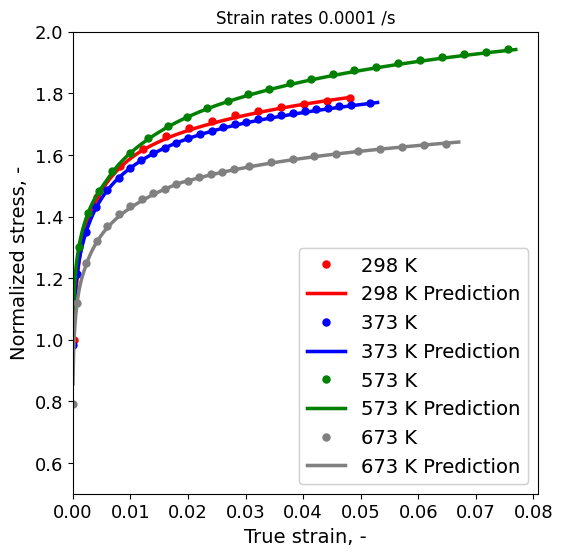

In [34]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4']['Strain'][::20], flows['e4']['Normalized Stress'][::20], '.', label='298 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e4']['Strain'], slstm_train_pred_stress['e4'][:,], label='298 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e4_373K']['Strain'][::20], flows['e4_373K']['Normalized Stress'][::20], '.', label='373 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e4_373K']['Strain'], slstm_train_pred_stress['e4_373K'][:,], label='373 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e4_573K']['Strain'][::20], flows['e4_573K']['Normalized Stress'][::20], '.', label='573 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e4_573K']['Strain'], slstm_train_pred_stress['e4_573K'][:,], label='573 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e4_673K']['Strain'][::20], flows['e4_673K']['Normalized Stress'][::20], '.', label='673 K', color='gray', alpha=1.0, markersize=10)
plt.plot(flows['e4_673K']['Strain'], slstm_train_pred_stress['e4_673K'][:,], label='673 K Prediction', color='gray', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.title('Strain rates 0.0001 /s')
plt.savefig('FC_Train_0.0001.png')

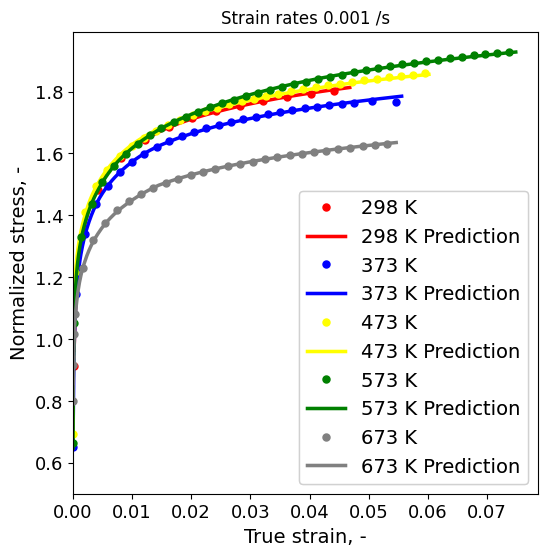

In [35]:
plt.figure(figsize=(6,6))

plt.plot(flows['e3']['Strain'][::20], flows['e3']['Normalized Stress'][::20], '.', label='298 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e3']['Strain'], slstm_train_pred_stress['e3'][:,], label='298 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_373K']['Strain'][::20], flows['e3_373K']['Normalized Stress'][::20], '.', label='373 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e3_373K']['Strain'], slstm_train_pred_stress['e3_373K'][:,], label='373 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_473K']['Strain'][::20], flows['e3_473K']['Normalized Stress'][::20], '.', label='473 K', color='yellow', alpha=1.0, markersize=10)
plt.plot(flows['e3_473K']['Strain'], slstm_train_pred_stress['e3_473K'][:,], label='473 K Prediction', color='yellow', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_573K']['Strain'][::20], flows['e3_573K']['Normalized Stress'][::20], '.', label='573 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e3_573K']['Strain'], slstm_train_pred_stress['e3_573K'][:,], label='573 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_673K']['Strain'][::20], flows['e3_673K']['Normalized Stress'][::20], '.', label='673 K', color='gray', alpha=1.0, markersize=10)
plt.plot(flows['e3_673K']['Strain'], slstm_train_pred_stress['e3_673K'][:,], label='673 K Prediction', color='gray', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.title('Strain rates 0.001 /s')
plt.savefig('FC_Train_0.001.png')

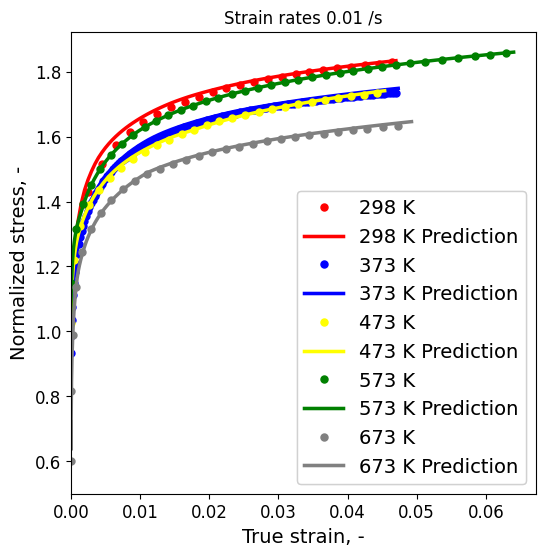

In [36]:
plt.figure(figsize=(6,6))

plt.plot(flows['e2']['Strain'][::4], flows['e2']['Normalized Stress'][::4], '.', label='298 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e2']['Strain'], slstm_train_pred_stress['e2'][:,], label='298 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_373K']['Strain'][::4], flows['e2_373K']['Normalized Stress'][::4], '.', label='373 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e2_373K']['Strain'], slstm_train_pred_stress['e2_373K'][:,], label='373 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_473K']['Strain'][::20], flows['e2_473K']['Normalized Stress'][::20], '.', label='473 K', color='yellow', alpha=1.0, markersize=10)
plt.plot(flows['e2_473K']['Strain'], slstm_train_pred_stress['e2_473K'][:,], label='473 K Prediction', color='yellow', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_573K']['Strain'][::20], flows['e2_573K']['Normalized Stress'][::20], '.', label='573 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e2_573K']['Strain'], slstm_train_pred_stress['e2_573K'][:,], label='573 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_673K']['Strain'][::20], flows['e2_673K']['Normalized Stress'][::20], '.', label='673 K', color='gray', alpha=1.0, markersize=10)
plt.plot(flows['e2_673K']['Strain'], slstm_train_pred_stress['e2_673K'][:,], label='673 K Prediction', color='gray', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.title('Strain rates 0.01 /s')
plt.savefig('FC_Train_0.01.png')

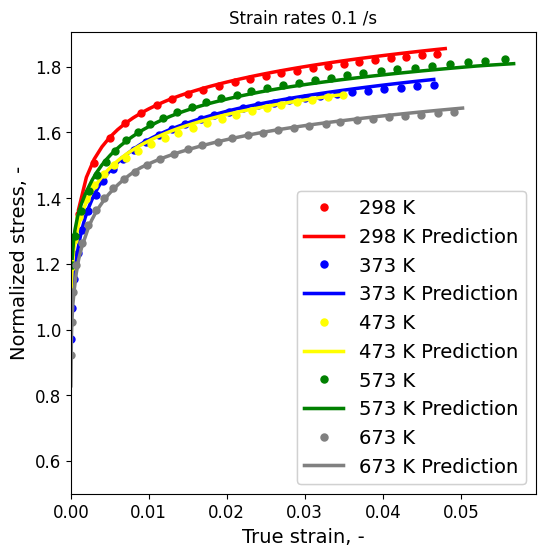

In [37]:
plt.figure(figsize=(6,6))

plt.plot(flows['e1']['Strain'][::2], flows['e1']['Normalized Stress'][::2], '.', label='298 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1']['Strain'], slstm_train_pred_stress['e1'], label='298 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_373K']['Strain'][::2], flows['e1_373K']['Normalized Stress'][::2], '.', label='373 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e1_373K']['Strain'], slstm_train_pred_stress['e1_373K'], label='373 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_473K']['Strain'][::2], flows['e1_473K']['Normalized Stress'][::2], '.', label='473 K', color='yellow', alpha=1.0, markersize=10)
plt.plot(flows['e1_473K']['Strain'], slstm_train_pred_stress['e1_473K'], label='473 K Prediction', color='yellow', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_573K']['Strain'][::2], flows['e1_573K']['Normalized Stress'][::2], '.', label='573 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e1_573K']['Strain'], slstm_train_pred_stress['e1_573K'], label='573 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_673K']['Strain'][::2], flows['e1_673K']['Normalized Stress'][::2], '.', label='673 K', color='gray', alpha=1.0, markersize=10)
plt.plot(flows['e1_673K']['Strain'], slstm_train_pred_stress['e1_673K'][:,], label='673 K Prediction', color='gray', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.title('Strain rates 0.1 /s')
plt.savefig('FC_Train_0.1.png')

### Testing results

In [38]:
slstm_test_pred_stress = {}
#slstm_test_pred_temp = {}
for key, X in X_test_dict.items():
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    slstm_test_pred_stress[key] = manual_descaling(best_slstm.predict(X)[:,0], stress_range)
    #slstm_test_pred_temp[key] = manual_descaling(best_slstm.predict(X)[:,1], delT_range)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


#### Stress predictions

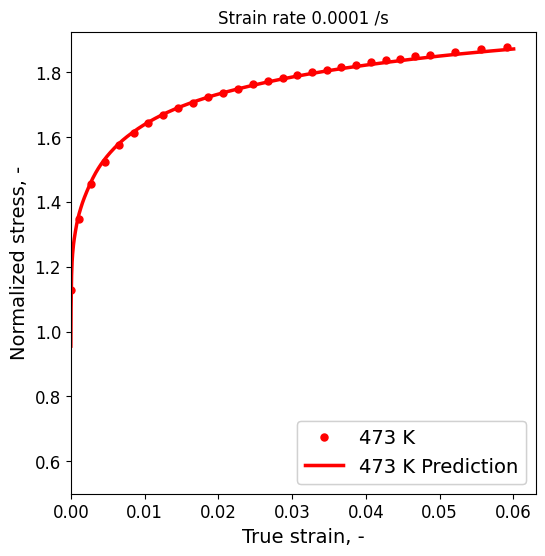

In [39]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4_473K']['Strain'][::20], flows['e4_473K']['Normalized Stress'][::20], '.', label='473 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e4_473K']['Strain'], slstm_test_pred_stress['e4_473K'][:,], label='473 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.title('Strain rate 0.0001 /s')
plt.savefig('FC_Test_0.0001.png')

/run/nvme/job_24745766/tmp/ipykernel_1653053/1013170867.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.gca().add_artist(plt.legend(loc=4, fontsize='14'))


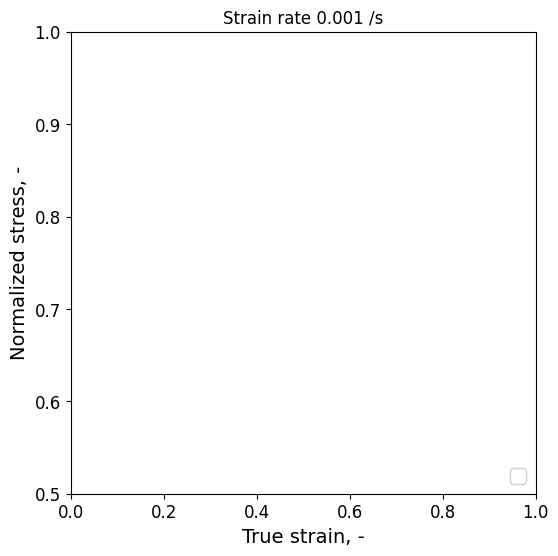

In [28]:
plt.figure(figsize=(6,6))

#plt.plot(flows['e3']['Strain'][::10], flows['e3']['Stress'][::10], '.', label='298 K', color='red', alpha=1.0, markersize=10)
#plt.plot(flows['e3']['Strain'], slstm_test_pred_stress['e3'][:,], label='298 K Prediction', color='red', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e3_473K']['Strain'][::20], flows['e3_473K']['Stress'][::20], '.', label='473 K', color='green', alpha=1.0, markersize=10)
#plt.plot(flows['e3_473K']['Strain'], slstm_test_pred_stress['e3_473K'][:,], label='473 K Prediction', color='green', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e3_673K']['Strain'][::20], flows['e3_673K']['Stress'][::20], '.', label='673 K', color='blue', alpha=1.0, markersize=10)
#plt.plot(flows['e3_673K']['Strain'], slstm_test_pred_stress['e3_673K'][:,], label='673 K Prediction', color='blue', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=4, fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.title('Strain rate 0.001 /s')
plt.savefig('FC_Test_0.001.png')

/run/nvme/job_24745766/tmp/ipykernel_1653053/7697590.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))


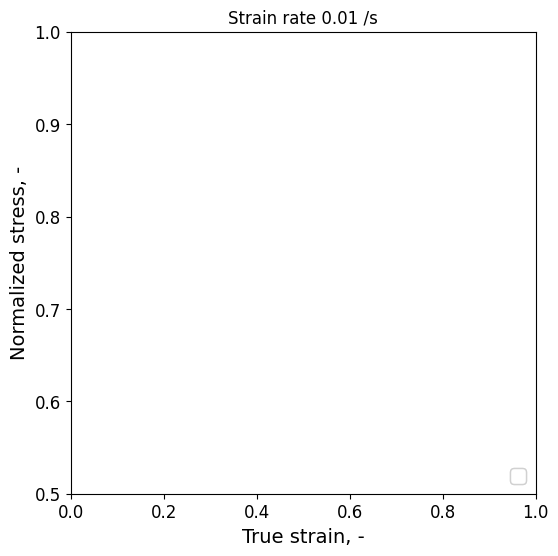

In [29]:
plt.figure(figsize=(6,6))

#plt.plot(flows['e2_373K']['Strain'][::20], flows['e2_373K']['Stress'][::20], '.', label='373 K', color='red', alpha=1.0, markersize=10)
#plt.plot(flows['e2_373K']['Strain'], slstm_test_pred_stress['e2_373K'][:,], label='373 K Prediction', color='red', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e2_573K']['Strain'][::20], flows['e2_573K']['Stress'][::20], '.', label='573 K', color='green', alpha=1.0, markersize=10)
#plt.plot(flows['e2_573K']['Strain'], slstm_test_pred_stress['e2_573K'][:,], label='573 K Prediction', color='green', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e2_673K']['Strain'][::20], flows['e2_673K']['Stress'][::20], '.', label='673 K', color='blue', alpha=1.0, markersize=10)
#plt.plot(flows['e2_673K']['Strain'], slstm_test_pred_stress['e2_673K'][:,], label='673 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.title('Strain rate 0.01 /s')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.savefig('FC_Test_0.01.png')

/run/nvme/job_24745766/tmp/ipykernel_1653053/3460679413.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))


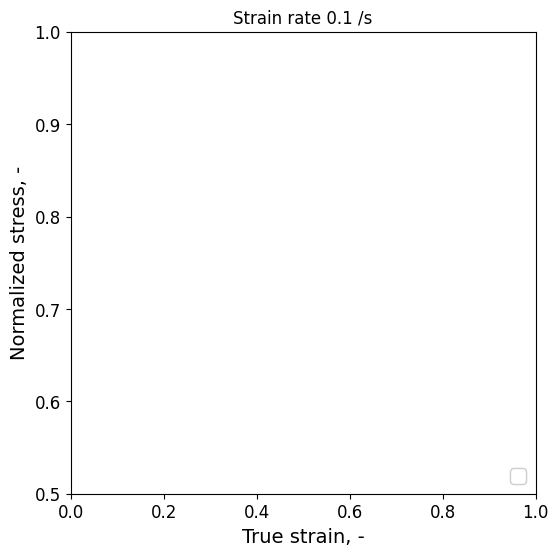

In [30]:
plt.figure(figsize=(6,6))

#plt.plot(flows['e1']['Strain'][::5], flows['e1']['Stress'][::5], '.', label='298 K', color='red', alpha=1.0, markersize=10)
#plt.plot(flows['e1']['Strain'], slstm_test_pred_stress['e1'][:,], label='298 K Prediction', color='red', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e1_373K']['Strain'][::5], flows['e1_373K']['Stress'][::5], '.', label='373 K', color='blue', alpha=1.0, markersize=10)
#plt.plot(flows['e1_373K']['Strain'], slstm_test_pred_stress['e1_373K'][:,], label='373 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e1_473K']['Strain'][::2], flows['e1_473K']['Stress'][::2], '.', label='473 K', color='green', alpha=1.0, markersize=10)
#plt.plot(flows['e1_473K']['Strain'], slstm_test_pred_stress['e1_473K'][:,], label='473 K Prediction', color='green', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e1_573K']['Strain'][::2], flows['e1_573K']['Stress'][::2], '.', label='573 K', color='red', alpha=1.0, markersize=10)
#plt.plot(flows['e1_573K']['Strain'], slstm_test_pred_stress['e1_573K'][:,], label='573 K Prediction', color='red', alpha=1.0, linewidth=2.5)

#plt.plot(flows['e1_673K']['Strain'][::2], flows['e1_673K']['Stress'][::2], '.', label='673 K', color='blue', alpha=1.0, markersize=10)
#plt.plot(flows['e1_673K']['Strain'], slstm_test_pred_stress['e1_673K'][:,], label='673 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Normalized stress, -', fontsize='14')    #Name y label

plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0.5)
plt.title('Strain rate 0.1 /s')
plt.savefig('FC_Test_0.1.png')